In [1]:
import requests
from requests import get
import os
import unicodedata
import re
import json

import acquire as a
import prepare as p

import pandas as pd # to handle the dataframe
import numpy as np
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Acquire and Prepare functions with train, validate and test
df = a.get_data(query_url = False)
print(df.shape)
df = p.prepare_dataframe(df)
train, validate, test = p.split_data(df)
train.shape, validate.shape, test.shape

Found file in working directory!
(70932, 83)


((53199, 63), (26599, 63), (26600, 63))

In [3]:
train.head()

,id,name,lang,released_at,layout,highres_image,image_status,mana_cost,cmc,type_line,...,hand_modifier,content_warning,flavor_name,usd,usd_foil,eur,eur_foil,is_foil,is_etched,is_glossy
12661,2d911053-a026-4b20-ba2d-dbcc367c1413,Ajani Goldmane,en,2010-07-16,normal,True,highres_scan,{2}{W}{W},4.0,Legendary Planeswalker — Ajani,...,0.0,False,no_flavor,8.02,15.11,8.02,15.11,True,False,False
61300,dcb2e0d6-3181-4d3d-a3b4-3896288b2e0e,Champion of Lambholt,en,2020-08-07,normal,True,highres_scan,{1}{G}{G},3.0,Creature — Human Warrior,...,0.0,False,no_flavor,0.36,3.22,0.36,3.22,True,False,False
48604,af3aa149-00fa-4932-b004-f64c8b5d3ca7,Gargoyle,en,2009-07-17,token,True,highres_scan,,0.0,Token Artifact Creature — Gargoyle,...,0.0,False,no_flavor,0.25,0.00,0.25,0.00,False,False,False
55734,c8d75604-4941-4faf-8f1a-7fc529e64962,Goblin Settler,en,2022-04-12,normal,True,highres_scan,{3}{R},4.0,Creature — Goblin,...,0.0,False,no_flavor,9.76,11.87,9.76,11.87,True,False,False
70638,feef03a1-f19a-413b-ad86-0b357cf9c09c,Weight Advantage,en,2016-08-26,normal,True,highres_scan,,0.0,Conspiracy,...,0.0,False,no_flavor,0.11,0.42,0.11,0.42,True,False,False


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53199 entries, 12661 to 1677
Data columns (total 63 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                53199 non-null  object        
 1   name              53199 non-null  object        
 2   lang              53199 non-null  object        
 3   released_at       53199 non-null  datetime64[ns]
 4   layout            53199 non-null  object        
 5   highres_image     53199 non-null  bool          
 6   image_status      53199 non-null  object        
 7   mana_cost         53199 non-null  object        
 8   cmc               53194 non-null  float64       
 9   type_line         53194 non-null  object        
 10  oracle_text       53199 non-null  object        
 11  power             53199 non-null  object        
 12  toughness         53199 non-null  object        
 13  colors            53199 non-null  object        
 14  color_identity    5

# Hypothesis 1
- H0:The amount of cards created is not = to the artist value.
- HA:The amount of cards created is not = to the artist value.

In [5]:
# Rarity card count
df.rarity.value_counts()

common      25755
rare        22792
uncommon    17468
mythic       4659
special       248
bonus          10
Name: rarity, dtype: int64

In [6]:
train['usd'].value_counts()

0.00       12933
0.10        1611
0.09        1301
0.08        1173
0.05        1150
           ...  
28.61          1
1787.50        1
29.78          1
44.23          1
55.99          1
Name: usd, Length: 2895, dtype: int64

<AxesSubplot:>

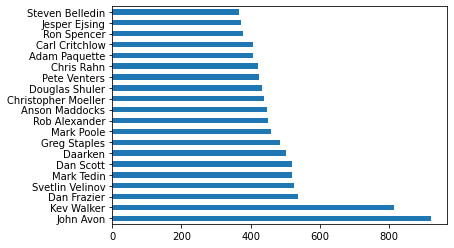

In [7]:
# Top 20 artist who created the most cards
train['artist'].value_counts()[:20].plot(kind='barh')

<AxesSubplot:>

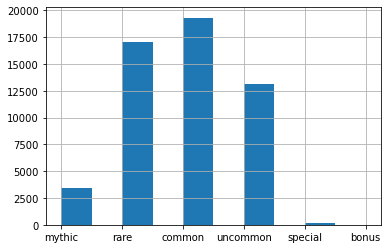

In [8]:
# Count of cards by rarity
train.rarity.hist()

In [9]:
# filter out lands and tokens 

train = train.loc[train['rarity'].isin(['common', 'uncommon', 'rare', 
                                        'mythic', 'special', 'bonus'])]
train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53199 entries, 12661 to 1677
Columns: 63 entries, id to is_glossy
dtypes: bool(17), datetime64[ns](1), float64(9), object(36)
memory usage: 19.9+ MB


This gives 53199 cards.

In [10]:
# show only data from the selected columns
df2 = train[['name', 'set_type', 'artist', 'rarity', 'usd', 'collector_number']]


In [11]:
# show only data from top 40 cards by price
df3 = df2.loc[:,'name':'collector_number'].sort_values(by=['usd'], ascending=False,)[:20]

In [12]:
df3

,name,set_type,artist,rarity,usd,collector_number
49832,Black Lotus,core,Christopher Rush,rare,11500.00,233
12737,Ancestral Recall,core,Mark Poole,rare,6999.99,48
47092,Tropical Island,core,Jesper Myrfors,rare,6000.00,283
497,Timetwister,core,Mark Tedin,rare,5732.99,85
9371,Mox Ruby,core,Dan Frazier,rare,5499.99,265
45705,Mox Emerald,core,Dan Frazier,rare,5279.99,262
70712,Bazaar of Baghdad,expansion,Jeff A. Menges,uncommon,4999.99,70
27959,The Tabernacle at Pendrell Vale,expansion,Nicola Leonard,rare,3888.00,307
31249,Mox Jet,core,Dan Frazier,rare,3099.99,263
48249,Time Walk,core,Amy Weber,rare,2999.00,84


In [13]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 49832 to 43725
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              20 non-null     object 
 1   set_type          20 non-null     object 
 2   artist            20 non-null     object 
 3   rarity            20 non-null     object 
 4   usd               20 non-null     float64
 5   collector_number  20 non-null     object 
dtypes: float64(1), object(5)
memory usage: 1.1+ KB


### Visualization

Used the top 100 cards based on value to chart results.

<AxesSubplot:>

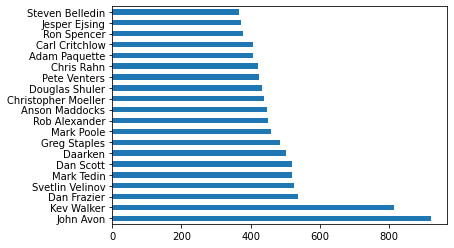

In [14]:
# Plot top 20 cards and artist by amount of cards created
train['artist'].value_counts().head(20).plot(kind='barh')



In [15]:
# Bar plor to show Artist and USD price, for top artist
def vis_artist_by_usd(train):
    train2 = train.sort_values(by=['usd'], ascending=False,)[:100]
    plt.figure(figsize=(10,10))
    sns.barplot(data=train2, x='usd', y='artist')
    plt.title('Rarity vs Artist/USD price')
    plt.xlabel('USD price')
    plt.ylabel('Artist name')
    plt.show()

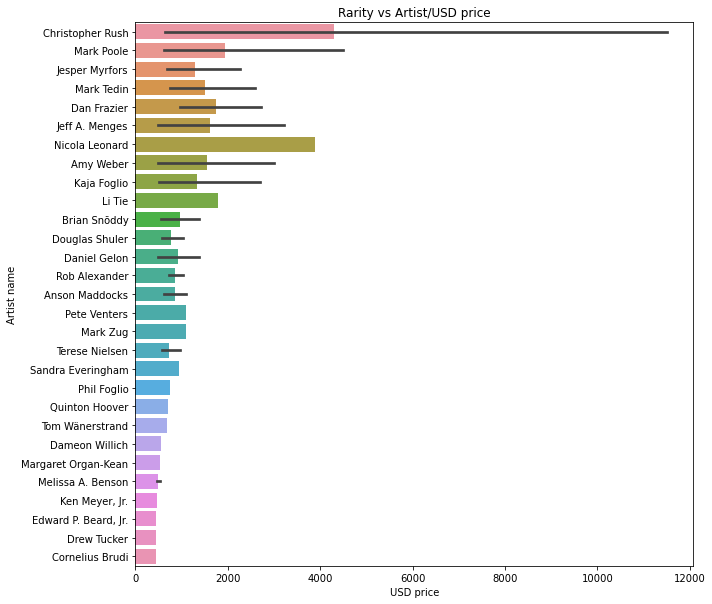

In [16]:
vis_artist_by_usd(train)

In [17]:
# Median price for all cards based on Rarity and USD price
def vis_rarity_by_usd(train):
    plt.figure(figsize=(10,10))
    sns.barplot(data=train, x='usd', y='rarity')
    plt.title('Median price: Rarity vs USD price')
    plt.xlabel('USD price')
    plt.ylabel('Artist name')
    plt.show()

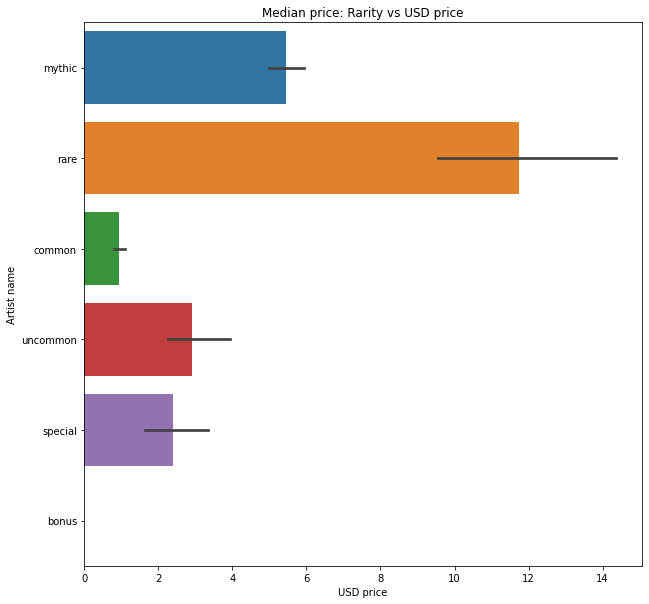

In [18]:
vis_rarity_by_usd(train)

In [19]:
df.rarity.value_counts()


common      25755
rare        22792
uncommon    17468
mythic       4659
special       248
bonus          10
Name: rarity, dtype: int64

### Key takeaway

- The amount of cards created is not = to the artist value.

- In the charts artist Jon Avon created the most cards but the artist Christopher Rush created the most expensive card(Black Lotus)



# Hypothesis 2
- H0: artist and rarity of cards is = to price 
- HA: artist and rarity of cards is not = to price

In [35]:
# Bar plot to show Artist, USD price and top 60 cards in the rarity category
def vis_artist_rarity_usd(train):
    train2 = train.sort_values(by=['usd'], ascending=False,)[:60]
    plt.figure(figsize=(10,10))
    sns.barplot(data=train2, x='usd', y='artist', hue='rarity')
    plt.title('Rarity vs Artist/USD price')
    plt.xlabel('USD price')
    plt.ylabel('Artist name')
    plt.show()



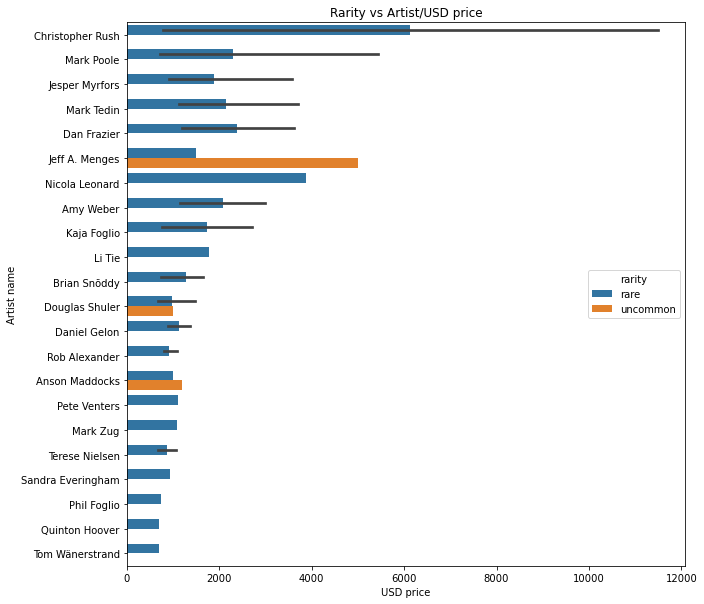

In [36]:
vis_artist_rarity_usd(train)

### Key takeaway

- The artist and rarity of cards is not equal to price

- In the charts only a few non-rare rarity cards are in the high value price range.


# Hypothesis 3
- H0: set_type and rarity of cards is = to price 
- HA: set_type and rarity of cards is not = to price

In [22]:
# Cards value count to set_types
df.set_type.value_counts()

expansion           22466
masters              8233
core                 7840
promo                7481
commander            5671
draft_innovation     4552
memorabilia          3204
box                  3090
duel_deck            1945
token                1613
starter              1115
funny                 971
planechase            647
alchemy               536
treasure_chest        431
masterpiece           373
archenemy             326
from_the_vault        157
vanguard              117
premium_deck          105
arsenal                35
spellbook              24
Name: set_type, dtype: int64

<AxesSubplot:xlabel='count', ylabel='set_type'>

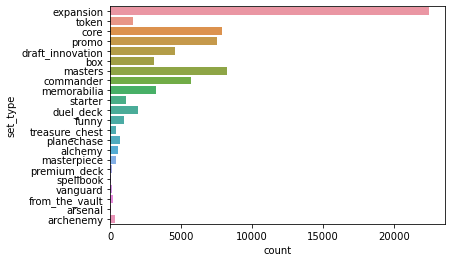

In [23]:
# Most expensive cards by set_type
sns.countplot(data= df, y='set_type')

In [42]:
# top 100 cards: Set_type and Rarity 
def usd_rarity_set_type_total(train):
    train2 = train.sort_values(by=['usd'], ascending=False,)[:100]
    plt.figure(figsize=(10,10))
    sns.barplot(data=train2, x='usd', y='set_type', hue='rarity', estimator=sum)
    plt.title('Price vs Set_type/Rarity')
    plt.xlabel('USD price')
    plt.ylabel('Set_type')
    plt.show()



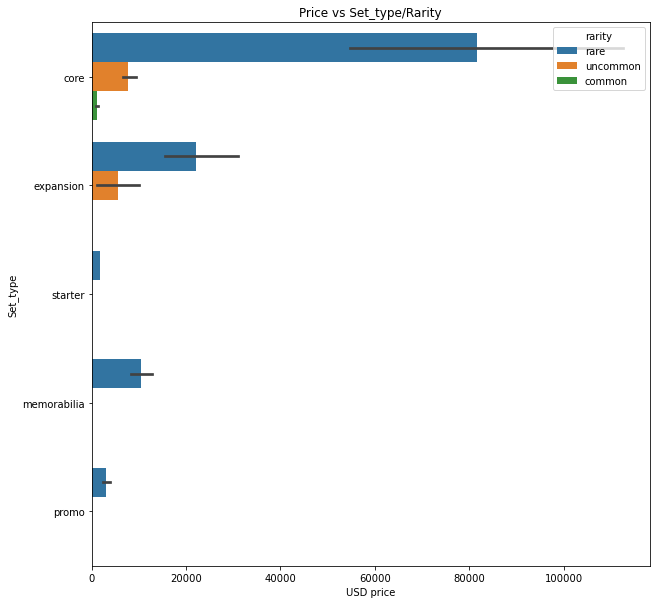

In [43]:
usd_rarity_set_type_total(train)

### Key takeaway

- Rare cards are the most expensive regardless of set_type

- In the charts there are only a few none rare cards in the top 100 high value price range.



Hypothesis 4
- Is there a relationship between collector number and usd?

In [25]:
# Amount of cards collected by top collectors.
train['collector_number'].value_counts()

1        434
5        388
4        384
2        384
3        379
        ... 
78p        1
ll129      1
E57        1
65648      1
1439       1
Name: collector_number, Length: 6406, dtype: int64

<AxesSubplot:>

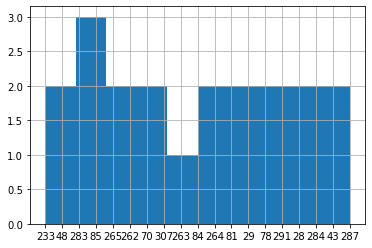

In [26]:
df3.collector_number.hist()

<AxesSubplot:xlabel='count', ylabel='collector_number'>

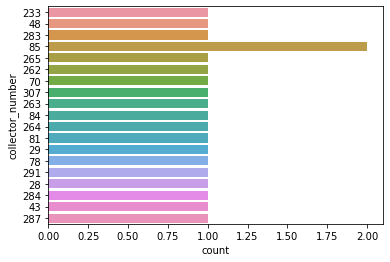

In [27]:
sns.countplot(data= df3, y='collector_number')

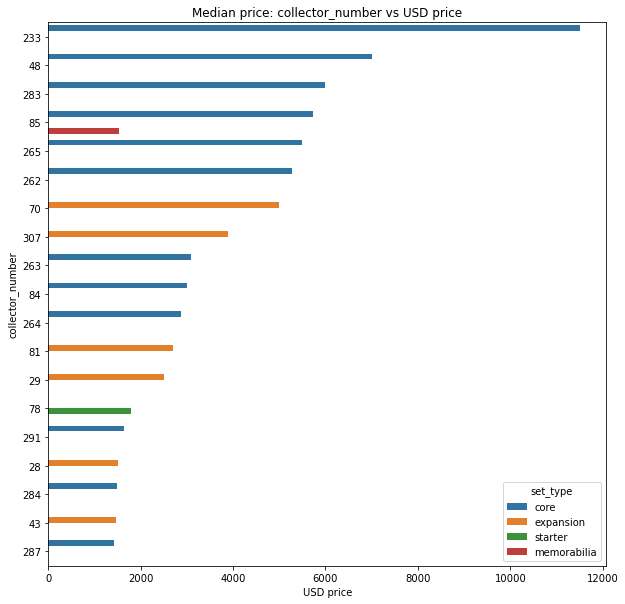

In [45]:
# Median price for all cards based Collector, Set Type and USD price
def vis_collector_set_by_usd(train):
    train2 = train.sort_values(by=['usd'], ascending=False,)[:20]
    plt.figure(figsize=(10,10))
    sns.barplot(data=train2, x='usd', y='collector_number', hue='set_type')
    plt.title('Median price: collector_number vs USD price')
    plt.xlabel('USD price')
    plt.ylabel('collector_number')
    plt.show()

vis_collector_set_by_usd(train)

Takeaway:
More information on the collecters would be need to complete this H0. But from this data it seems that the top collecters do seem to collects mostly core and expansion cards.

# Other Testing

In [53]:
df.mana_cost.value_counts()

                       9882
{1}{W}                 1925
no_mana_cost           1844
{1}{G}                 1764
{2}{G}                 1675
                       ... 
{10}{G}{G}{G}{W}{W}       1
{3}{R/W}                  1
{5}{U}{B}{R}              1
{8}{B}{B}{B}              1
{1}{R} // {3}{G}          1
Name: mana_cost, Length: 885, dtype: int64

<AxesSubplot:>

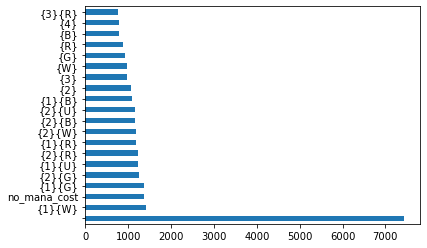

In [54]:
train['mana_cost'].value_counts()[:20].plot(kind='barh')